## Imports

In [ ]:
################ Run if needed################
#import zipfile
#with zipfile.ZipFile("dataset.zip","r") as zip_ref:
#    zip_ref.extractall("dataset")

In [5]:
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import transforms, utils, models

import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

import numpy as np 
import PIL
import os
import mat73
from tqdm import tqdm
import matplotlib.pyplot as plt 
%matplotlib inline

import copy
import time

plt.ion()

## Data loading

In [2]:
###############################################################

In [17]:
from collections import Counter################################
Counter(data_labels) ##########################################

Counter({1: 708, 3: 930, 2: 1426})

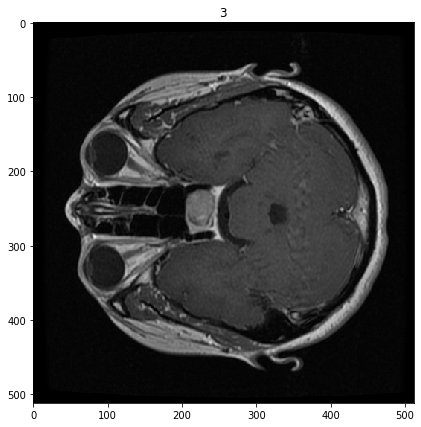

In [10]:
fig= plt.figure(figsize=(7, 7))
plt.imshow(data_struct[3][0], cmap='gray')
plt.title(data_struct[3][1])
plt.show()

In [3]:
########### try using balanced classes 708 930 1000 ###########

## Data loader

In [6]:
class BrainTumorDataset(Dataset):
    def __init__(self, dir, transform=None):

        self.files = os.listdir(dir)
        self.data_struct = []
        self.transform = transform

        for file in tqdm(self.files):
            data_dict = mat73.loadmat(dir + file)
            self.data_struct.append([data_dict['cjdata']['image'], int(data_dict['cjdata']['label'])])
            
    def __len__(self):
        return len(self.data_struct)

    def __getitem__(self, index):

        image = PIL.Image.fromarray(self.data_struct[index][0])

        if self.transform:
            image = self.transform(image)

        label = self.data_struct[index][1]

        sample = image , label
        return sample

In [7]:
data_transform = transforms.Compose([transforms.Resize(256),
                                     transforms.ToTensor()])

In [8]:
dataset = BrainTumorDataset('dataset/dataset/', transform=data_transform)

batch_size = 16
test_size = .2
valid_size = .2
shuffle_dataset = True
seed= 69

dataset_size = len(dataset)
train_split = int(np.floor(dataset_size - dataset_size * (test_size + valid_size) ))
test_split = int(np.floor(train_split + dataset_size * test_size ))

indices = list(range(dataset_size))
if shuffle_dataset :
    np.random.seed(seed)
    np.random.shuffle(indices)

train_indices, test_indices, valid_indices = indices[:train_split], indices[train_split: test_split], indices[test_split:]

train_sampler = SubsetRandomSampler(train_indices)
test_sampler = SubsetRandomSampler(test_indices)
valid_sampler = SubsetRandomSampler(valid_indices)

train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
test_loader = DataLoader(dataset, batch_size=batch_size, sampler=test_sampler)
valid_loader = DataLoader(dataset, batch_size=batch_size, sampler=valid_sampler)

100%|██████████| 3064/3064 [00:36<00:00, 84.54it/s]


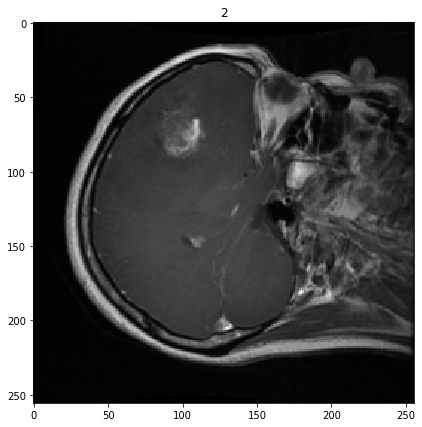

In [9]:
images, labels = next(iter(train_loader))
fig= plt.figure(figsize=(7, 7))
plt.imshow(images[0][0], cmap='gray')
plt.title(int(labels[0]))
plt.show()

In [10]:
###############################################################
print(len(train_indices))
print(len(test_indices))
print(len(valid_indices))

1838
612
614


In [1]:
##################### Network#################

In [30]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
                dataloader = train_loader
            else:
                model.eval()   # Set model to evaluate mode
                dataloader = valid_loader

            running_loss = 0.0
            running_corrects = 0


            # Iterate over data.
            for inputs, labels in dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model


In [24]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(valid_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [25]:
network = models.vgg11_bn(pretrained=False)
network

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2d(ke

In [17]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [26]:
network = network.to(device)

In [20]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(network.parameters(), lr=0.003, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [31]:
network = train_model(network, criterion, optimizer, exp_lr_scheduler, num_epochs=5)

RuntimeError: CUDA out of memory. Tried to allocate 16.00 MiB (GPU 0; 4.00 GiB total capacity; 2.96 GiB already allocated; 2.20 MiB free; 2.99 GiB reserved in total by PyTorch)